In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.stattools import adfuller
import itertools
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

Leemos la factura mediana

In [2]:
factura_mediana = pd.read_csv(r"C:\Users\innig\Documents\IDBOOTCAMP\TRABAJO FINAL\ARCHIVOS\factura_final_mediana.csv")
factura_mediana

,Codigo,Producto,Unidades,Precio,Num_Factura,Precio_Unit,Fecha,Total,Coste,Seccion,Margen_Producto,%_Margen_Producto
0,1119,Fruta al peso,1.11,1.05,1,0.95,2015-08-16,1.05,0.7600,7.0,0.1900,0.20
1,1035,Cerveza 33cl SKOL,6.00,3.00,2,0.50,2015-08-16,3.00,0.2800,10.0,0.2200,0.44
2,1031,"Cerveza sin 0,0 33cl SAN MIGUEL",1.00,0.70,3,0.70,2015-08-20,1.90,0.3990,10.0,0.3010,0.43
3,1060,"Agua 1,5L BEZOYA",1.00,0.70,3,0.70,2015-08-20,1.90,0.3570,10.0,0.3430,0.49
4,421,Tomate frito 265gr brick ORLANDO,1.00,0.50,3,0.50,2015-08-20,1.90,0.3000,7.0,0.2000,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...
1242430,7164,Donettes clasicos,1.00,1.99,467110,1.99,2022-11-01,7.84,1.2736,7.0,0.7164,0.36
1242431,1078,Chuches 0.05,2.00,0.10,467111,0.05,2022-11-01,0.10,0.0400,7.0,0.0100,0.20
1242432,1118,Producto de Oferta,1.00,1.00,467112,1.00,2022-11-01,4.45,0.8000,7.0,0.2000,0.20
1242433,8689,Palmera bollo,1.00,1.25,467112,1.25,2022-11-01,4.45,1.0000,7.0,0.2500,0.20


In [3]:
factura_mediana.drop([0,1],axis=0,inplace=True)

Tratamos las tablas para llegar hasta nuestra serie diaria de Unidades

In [4]:
factura_mediana["Beneficio_Por_Producto"] = factura_mediana["Precio"] * factura_mediana["%_Margen_Producto"]
factura_mediana["Fecha"] = factura_mediana['Fecha'].apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S'))
factura_mediana.index = factura_mediana.Fecha
df = factura_mediana[["Total","Unidades","Beneficio_Por_Producto","Num_Factura"]]
df.loc[df.Num_Factura == df.Num_Factura.shift(), "Total"] = 0
df_diario = df.groupby(df.index).sum()
ts = df_diario["Unidades"]
ts

Fecha
2015-08-20      24.000
2015-08-21      87.305
2015-08-22       6.000
2015-08-23     539.495
2015-08-24     595.615
                ...   
2022-10-28     539.805
2022-10-29     667.615
2022-10-30    1142.970
2022-10-31     581.820
2022-11-01     848.400
Name: Unidades, Length: 2629, dtype: float64

Descomposicion

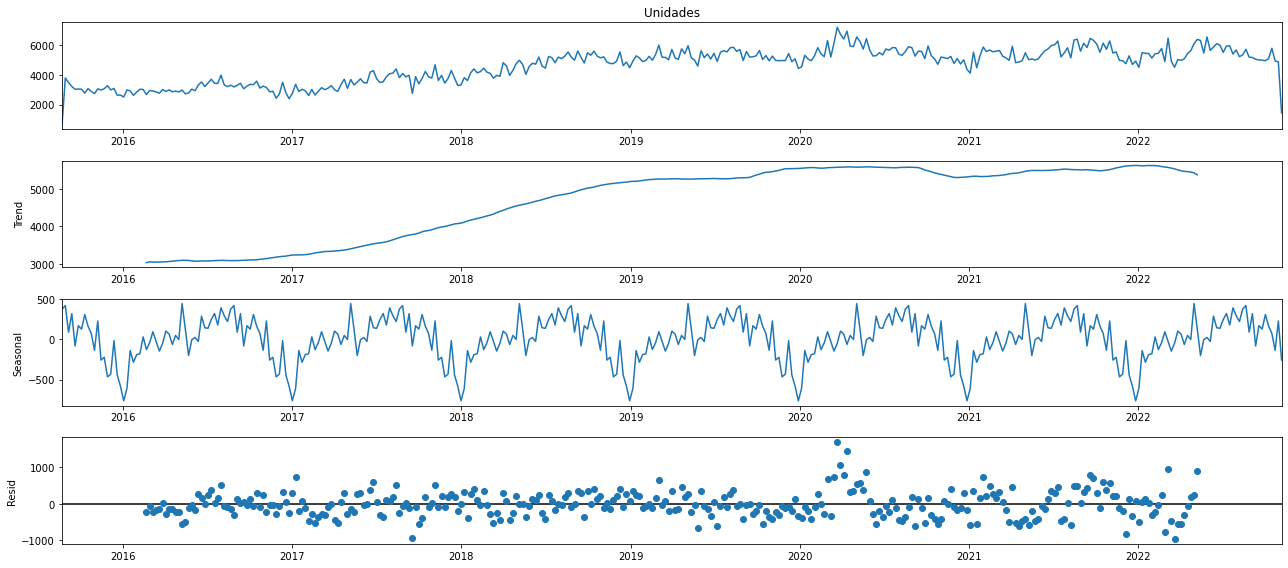

In [5]:
# Semanal
descomposicion = sm.tsa.seasonal_decompose(ts.resample("w").sum(), model='additive')
fig = descomposicion.plot()
plt.show()

Comprobamos si es estacionaria en media. 

Hacemos una funcion para ver el test de adfuller para ver si es estacionaria en media y graficamos la serie temporal con las medias y desviaciones moviles

In [6]:
def estacionariedad(serie_temporal):
    
    # Determinando las medias y desviaciones moviles
    media_movil30 = pd.Series(serie_temporal).rolling(window = 30).mean()
    media_movil90 = pd.Series(serie_temporal).rolling(window = 90).mean()
    std_movil30 = pd.Series(serie_temporal).rolling(window = 30).std()
    std_movil90 = pd.Series(serie_temporal).rolling(window = 90).std()
    
    # Grafico 
    plt.plot(serie_temporal, color='blue',label='Serie Original')
    plt.plot(media_movil30, color='red', label='Media Movil 30')
    plt.plot(std_movil30, color='black', label = 'STD Movil 30')
    plt.plot(media_movil90, color="yellow",label='Media Movil 90')
    plt.plot(std_movil90, color="green", label='STD Movil 90')
    plt.legend(loc='best')
    plt.title('Media Movil & Desviacion Tipica')
    plt.show(block=False)
    
    #Aplicacion de test de Dickey-Fuller:
    print ('Resultados AD-Fuller test:')
    dftest = adfuller(serie_temporal, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

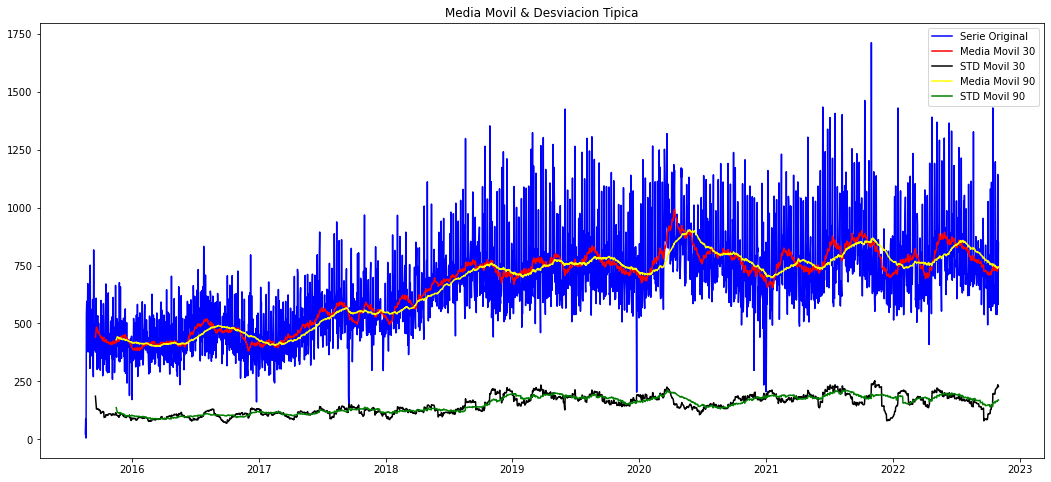

Resultados AD-Fuller test:
Test Statistic                   -1.938286
p-value                           0.314270
Lags Used                        27.000000
Number of Observations Used    2601.000000
Critical Value (1%)              -3.432867
Critical Value (5%)              -2.862652
Critical Value (10%)             -2.567362
dtype: float64


In [7]:
estacionariedad(ts)

In [8]:
# Como vemos que el p-valor es superior a 0,05, sabemos que la serie no es estacionaria en media.

Comprobamos si la serie es estacionaria o no en varianza

In [9]:
centralidad = np.log(ts.resample('w').mean())
dispersion = np.log(ts.resample('w').std())
model = sm.OLS(dispersion, sm.add_constant(centralidad)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Unidades   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     141.5
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           6.66e-28
Time:                        13:35:08   Log-Likelihood:                -121.50
No. Observations:                 377   AIC:                             247.0
Df Residuals:                     375   BIC:                             254.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0287      0.416     -0.069      0.945      -0.848       0.790
Unidades       0.7659      0.064     11.895      0.000       0.639       0.892
==============================================================================
Omnibus:                       22.874   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.706
Skew:                          -0.247   Prob(JB):                     4.86e-13
Kurtosis:                       4.835   Cond. No.                         160.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Como el coeficiente de las unidades es bastante alto(0,7659), podemos decir que la serie no es estacionaria en varianza

Transformamos la serie con el logaritmo y la graficamos con las medias moviles de la serie transformada

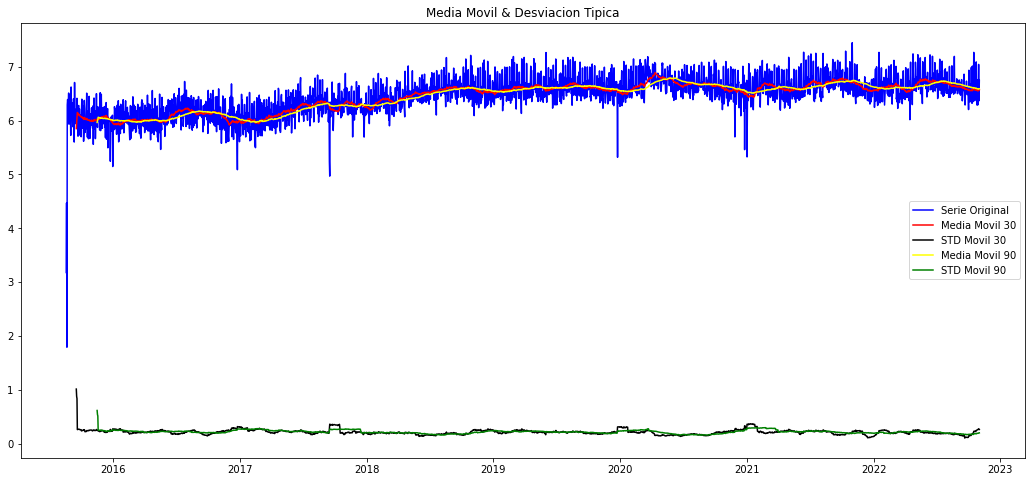

Resultados AD-Fuller test:
Test Statistic                   -1.993149
p-value                           0.289585
Lags Used                        28.000000
Number of Observations Used    2600.000000
Critical Value (1%)              -3.432868
Critical Value (5%)              -2.862652
Critical Value (10%)             -2.567362
dtype: float64


In [11]:
ts_log = np.log(ts)
estacionariedad(ts_log)

In [12]:
# Vemos que aun haciendo el logaritmo, el p-valor sigue siendo superior a 0,05. Hay que diferenciar.

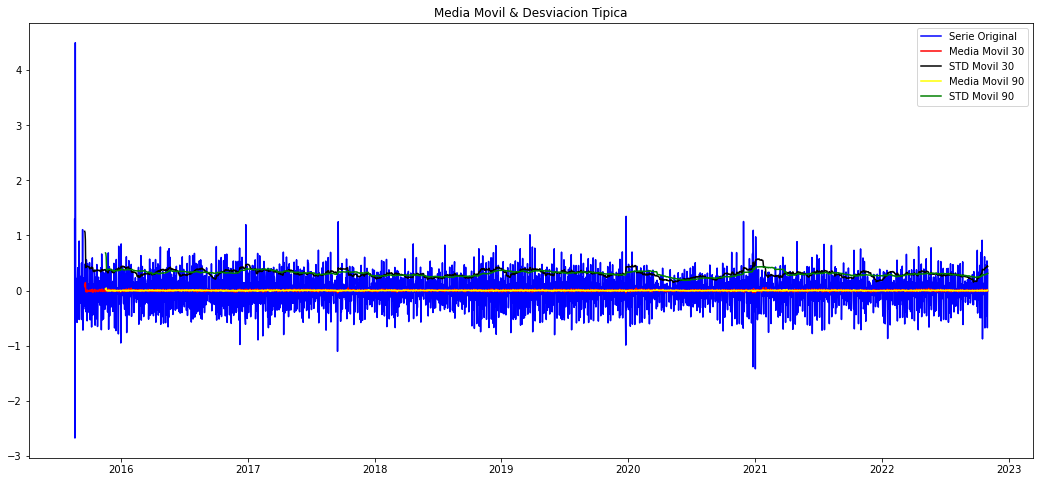

Resultados AD-Fuller test:
Test Statistic                -1.520012e+01
p-value                        5.845477e-28
Lags Used                      2.600000e+01
Number of Observations Used    2.601000e+03
Critical Value (1%)           -3.432867e+00
Critical Value (5%)           -2.862652e+00
Critical Value (10%)          -2.567362e+00
dtype: float64


In [13]:
ts_log_diff = ts_log.diff(1)
ts_log_diff.dropna(inplace=True)
estacionariedad(ts_log_diff)

In [14]:
# Vemos que al hacer la diferenciacion, el p-valor si que es muy cercano a 0.

In [15]:
###### split into train and test sets
train_log = ts_log[:-30]
test_log = ts_log[-30:]

Hacemos la busqueda de los mejores parametros. Realizaremos dos modelos, a 7 y 365 dias.

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))] 

In [17]:
mejores_resultados1 = {}
mejores_resultados2 = {}
for parametro in pdq:
    for param_s in seasonal_pdq:
        modelo = sm.tsa.statespace.SARIMAX(train_log,
                                                order = parametro,
                                                seasonal_order = param_s,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
        resultados = modelo.fit()
        indices = (parametro, param_s)
        mejores_resultados1[indices]=[resultados.aic]
        mejores_resultados2[indices]=[resultados.mse]

C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

In [18]:
print(min(mejores_resultados1.items(), key=lambda x: x[1]))
print(min(mejores_resultados2.items(), key=lambda x: x[1]))

(((1, 0, 1), (1, 1, 1, 7)), [-1697.1550009767898])
(((1, 1, 1), (1, 0, 0, 7)), [0.05565350568440677])


### MODELO 1

In [19]:
modelo1 = sm.tsa.statespace.SARIMAX(train_log,order=(1,0,1),seasonal_order=(1,1,1,7)).fit()
modelo1.summary()

C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          Unidades   No. Observations:                 2599
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood                 494.720
Date:                           Fri, 16 Dec 2022   AIC                           -979.441
Time:                                   13:36:08   BIC                           -950.140
Sample:                                        0   HQIC                          -968.823
                                          - 2599                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7741      0.031     25.371      0.000       0.714       0.834
ma.L1         -0.5556      0.034    -16.405      0.000      -0.622      -0.489
ar.S.L7        0.0565      0.013      4.502      0.000       0.032       0.081
ma.S.L7       -0.8664      0.010    -89.031      0.000      -0.885      -0.847
sigma2         0.0398      0.000     86.447      0.000       0.039       0.041
===================================================================================
Ljung-Box (L1) (Q):                   8.36   Jarque-Bera (JB):             91867.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             1.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\innig\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


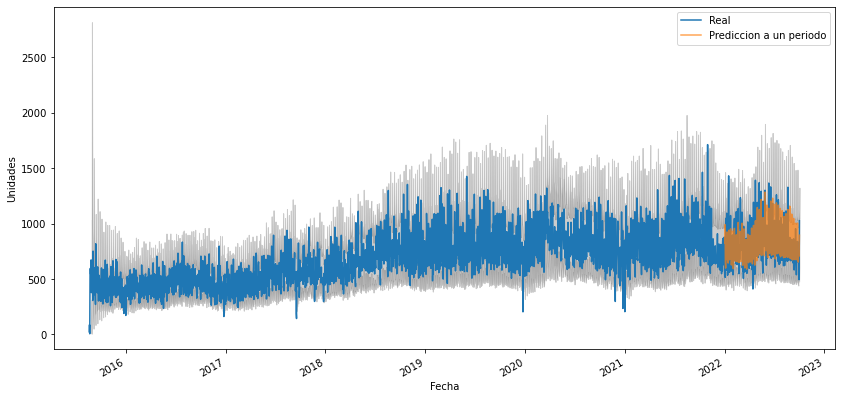

In [20]:
prediccion1 = modelo1.get_prediction()
media_prediccion1 = np.exp(prediccion1.predicted_mean)
ic_prediccion1 = np.exp(prediccion1.conf_int())
ax = np.exp(train_log).plot(label='Real')
media_prediccion1['2022':].plot(
        ax=ax, label='Prediccion a un periodo', alpha=.7, figsize=(14, 7))

ax.fill_between(ic_prediccion1.index,
                ic_prediccion1.iloc[:, 0],
                ic_prediccion1.iloc[:, 1], color='k', alpha=.2)

ax.set_ylabel('Unidades')
plt.legend()
plt.show()

In [21]:
valor_predicho1 = np.exp(modelo1.get_prediction().predicted_mean['2022':])
valor_real1 = np.exp(train_log)['2022':]

mse = ((valor_predicho1 - valor_real1) ** 2).mean()
pct_err = (abs(valor_predicho1-valor_real1)/valor_predicho1).mean()*100
print('El error cuadrático medio de la predicción es: {}'.format(round(mse, 2)))
print('Y el error en millones {}'.format(round(np.sqrt(mse), 2)))
print('El error porcentual {}%'.format(round(pct_err,2)))

El error cuadrático medio de la predicción es: 17253.28
Y el error en millones 131.35
El error porcentual 12.08%


In [22]:
# Realizamos el forecast a 30 dias

In [23]:
pred1 = modelo1.get_forecast(30) 
pred1.predicted_mean
ic_pred1 = pred1.conf_int()

C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [24]:
pred1.predicted_mean = pred1.predicted_mean.set_axis(test_log.index)
ic_pred1 = ic_pred1.set_index(test_log.index)

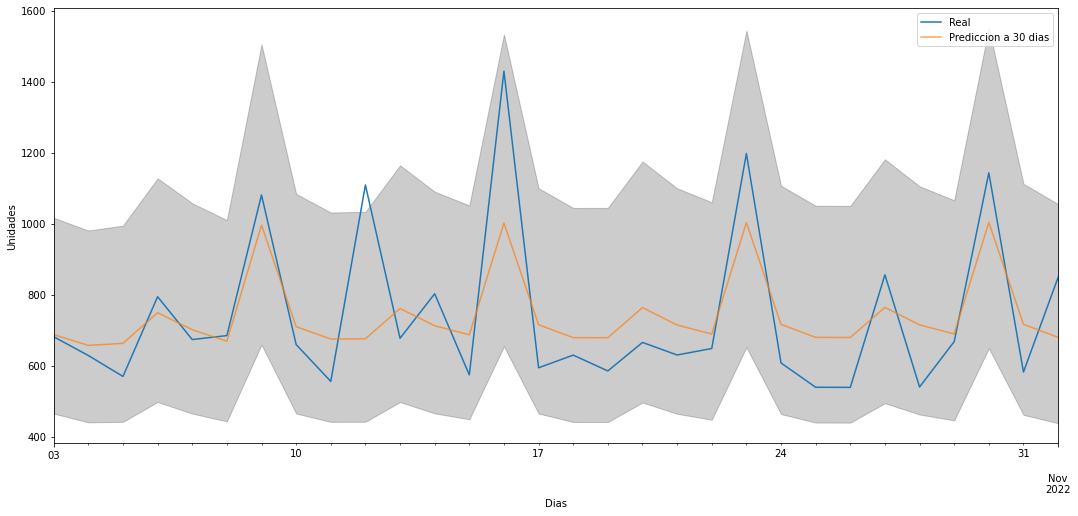

In [25]:
ax = np.exp(test_log).plot(label='Real')
plt.plot(np.exp(pred1.predicted_mean),label = 'Prediccion a 30 dias',alpha=.7)

ax.fill_between(ic_pred1.index,
                np.exp(ic_pred1["upper Unidades"].values),
                np.exp(ic_pred1["lower Unidades"].values), color='k', alpha=.2)

ax.set_ylabel('Unidades')
ax.set_xlabel('Dias')
plt.legend()
plt.show()

In [26]:
valor_futuro_predicho1 = np.exp(pred1.predicted_mean)
valor_real = np.exp(test_log)

mse = ((valor_futuro_predicho1 - valor_real) ** 2).mean()
pct_err = (abs(valor_futuro_predicho1-valor_real)/valor_futuro_predicho1).mean()*100
print('El error cuadrático medio de la predicción es: {}'.format(round(mse, 2)))
print('Y el error en millones {}'.format(round(np.sqrt(mse), 2)))
print('El error porcentual {}%'.format(round(pct_err,2)))

El error cuadrático medio de la predicción es: 22485.37
Y el error en millones 149.95
El error porcentual 15.12%


### MODELO 2

In [27]:
modelo2 = sm.tsa.statespace.SARIMAX(train_log,order=(1,1,1),seasonal_order=(1,0,0,7)).fit()
modelo2.summary()

C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Unidades   No. Observations:                 2599
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                 248.422
Date:                            Fri, 16 Dec 2022   AIC                           -488.844
Time:                                    13:36:10   BIC                           -465.394
Sample:                                         0   HQIC                          -480.347
                                           - 2599                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1595      0.008     19.750      0.000       0.144       0.175
ma.L1         -0.9816      0.005   -212.330      0.000      -0.991      -0.972
ar.S.L7        0.5087      0.005     94.182      0.000       0.498       0.519
sigma2         0.0483      0.000    114.265      0.000       0.047       0.049
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             45389.22
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\innig\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


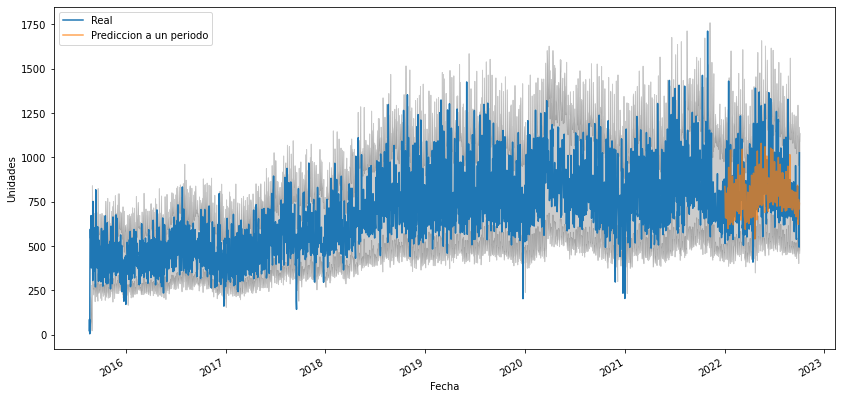

In [28]:
prediccion2 = modelo2.get_prediction()
media_prediccion2 = np.exp(prediccion2.predicted_mean)
ic_prediccion2 = np.exp(prediccion2.conf_int())
ax = np.exp(train_log).plot(label='Real')
media_prediccion2['2022':].plot(
        ax=ax, label='Prediccion a un periodo', alpha=.7, figsize=(14, 7))

ax.fill_between(ic_prediccion2.index,
                ic_prediccion2.iloc[:, 0],
                ic_prediccion2.iloc[:, 1], color='k', alpha=.2)

ax.set_ylabel('Unidades')
plt.legend()
plt.show()

In [29]:
valor_predicho2 = np.exp(modelo2.get_prediction().predicted_mean['2022':])
valor_real2 = np.exp(train_log)

mse = ((valor_predicho2 - valor_real2) ** 2).mean()
pct_err = (abs(valor_predicho1-valor_real2)/valor_predicho2).mean()*100
print('El error cuadrático medio de la predicción es: {}'.format(round(mse, 2)))
print('Y el error en millones {}'.format(round(np.sqrt(mse), 2)))
print('El error porcentual {}%'.format(round(pct_err,2)))

El error cuadrático medio de la predicción es: 20691.22
Y el error en millones 143.84
El error porcentual 12.19%


In [30]:
# Realizamos el forecast a 30 dias

In [31]:
pred2 = modelo2.get_forecast(30) 
pred2.predicted_mean
ic_pred2 = pred2.conf_int()

C:\Users\innig\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [32]:
pred2.predicted_mean = pred1.predicted_mean.set_axis(test_log.index)
ic_pred2 = ic_pred1.set_index(test_log.index)

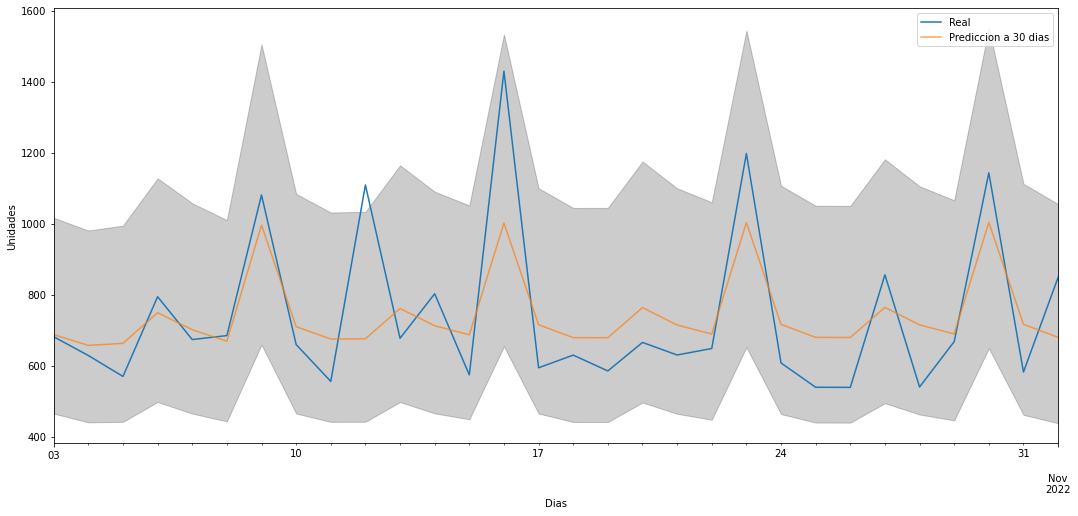

In [33]:
ax = np.exp(test_log).plot(label='Real')
plt.plot(np.exp(pred2.predicted_mean),label = 'Prediccion a 30 dias',alpha=.7)

ax.fill_between(ic_pred2.index,
                np.exp(ic_pred2["upper Unidades"].values),
                np.exp(ic_pred2["lower Unidades"].values), color='k', alpha=.2)

ax.set_ylabel('Unidades')
ax.set_xlabel('Dias')
plt.legend()
plt.show()

In [34]:
valor_futuro_predicho2 = np.exp(pred2.predicted_mean)
valor_real2 = np.exp(test_log)

mse = ((valor_futuro_predicho2 - valor_real2) ** 2).mean()
pct_err = (abs(valor_futuro_predicho2-valor_real2)/valor_futuro_predicho2).mean()*100
print('El error cuadrático medio de la predicción es: {}'.format(round(mse, 2)))
print('Y el error en millones {}'.format(round(np.sqrt(mse), 2)))
print('El error porcentual {}%'.format(round(pct_err,2)))

El error cuadrático medio de la predicción es: 22485.37
Y el error en millones 149.95
El error porcentual 15.12%
